In [1]:
!pip install split-folders

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghifarullah19","key":"3590d1acba3cb11884e3f09a427c346a"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d lutfi213040014/raw-plant

Dataset URL: https://www.kaggle.com/datasets/lutfi213040014/raw-plant
License(s): unknown
 96% 403M/418M [00:03<00:00, 147MB/s]
100% 418M/418M [00:03<00:00, 123MB/s]


In [6]:
import zipfile
import os

with zipfile.ZipFile('raw-plant.zip', 'r') as zip_ref:
    zip_ref.extractall('raw-plant')

In [9]:
import numpy as np
import tensorflow as tf
import zipfile, os
from splitfolders import ratio
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [10]:
base_plant = "/content/tmp/plant-cv-images"

In [11]:
ratio('/content/raw-plant/botanify-360', output=base_plant, seed=1337, ratio=(.8, .2))
train_dir_plant = os.path.join(base_plant, 'train')
val_dir_plant = os.path.join(base_plant, 'val')

Copying files: 10440 files [00:01, 6516.39 files/s]


In [12]:
os.listdir(train_dir_plant)

['Lily Flower',
 'Iris',
 'Pansy',
 'Orchid',
 'Dandelion',
 'Dieffenbacia',
 'Ixora',
 'Rose',
 'Tuberose',
 'Tulip',
 'Peony',
 'Gerbera',
 'Azalea',
 'Cosmos',
 'Eustoma',
 'Aster',
 'Jasmine',
 'Sunflower',
 'Lavender',
 'Aglaonema',
 'Bergamot',
 'Viola',
 'Alyssum',
 'Dahlia',
 'Sage',
 'Snapdragon',
 'Euphorbia',
 'Daisy',
 'Polyanthus']

In [13]:
os.listdir(val_dir_plant)

['Lily Flower',
 'Iris',
 'Pansy',
 'Orchid',
 'Dandelion',
 'Dieffenbacia',
 'Ixora',
 'Rose',
 'Tuberose',
 'Tulip',
 'Peony',
 'Gerbera',
 'Azalea',
 'Cosmos',
 'Eustoma',
 'Aster',
 'Jasmine',
 'Sunflower',
 'Lavender',
 'Aglaonema',
 'Bergamot',
 'Viola',
 'Alyssum',
 'Dahlia',
 'Sage',
 'Snapdragon',
 'Euphorbia',
 'Daisy',
 'Polyanthus']

In [14]:
train_plant_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  shear_range=0.2,
  fill_mode='nearest'
)

test_plant_datagen = ImageDataGenerator(
  rescale=1./255
)

In [15]:
train_plant_generator = train_plant_datagen.flow_from_directory(
  train_dir_plant,
  target_size=(224, 224),
  batch_size=32,
  class_mode='sparse'
)

validation_plant_generator = test_plant_datagen.flow_from_directory(
  val_dir_plant,
  target_size=(224, 224),
  batch_size=32,
  class_mode='sparse'
)

Found 8352 images belonging to 29 classes.
Found 2088 images belonging to 29 classes.


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(29, activation='softmax')
])

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95) and (logs.get('val_accuracy') > 0.9):
      print("\nAkurasi telah mencapai > 95%!")
      self.model.stop_training = True

callbacks = myCallback()

In [20]:
history = model.fit(
  train_plant_generator,
  epochs=10,
  validation_data=validation_plant_generator,
  verbose=1,
  callbacks=[callbacks]
)

Epoch 1/10
261/261 [==============================] - 106s 378ms/step - loss: 3.3180 - accuracy: 0.0511 - val_loss: 3.2382 - val_accuracy: 0.0723
Epoch 2/10
261/261 [==============================] - 97s 370ms/step - loss: 3.0580 - accuracy: 0.1292 - val_loss: 2.8466 - val_accuracy: 0.1897
Epoch 3/10
261/261 [==============================] - 95s 366ms/step - loss: 2.4870 - accuracy: 0.2744 - val_loss: 1.9925 - val_accuracy: 0.4277
Epoch 4/10
261/261 [==============================] - 96s 368ms/step - loss: 1.7207 - accuracy: 0.4860 - val_loss: 0.9809 - val_accuracy: 0.7203
Epoch 5/10
261/261 [==============================] - 96s 369ms/step - loss: 0.9658 - accuracy: 0.7112 - val_loss: 0.3702 - val_accuracy: 0.8946
Epoch 6/10
261/261 [==============================] - 97s 370ms/step - loss: 0.4878 - accuracy: 0.8495 - val_loss: 0.1813 - val_accuracy: 0.9473
Epoch 7/10
261/261 [==============================] - 95s 364ms/step - loss: 0.2938 - accuracy: 0.9113 - val_loss: 0.0618 - val_a

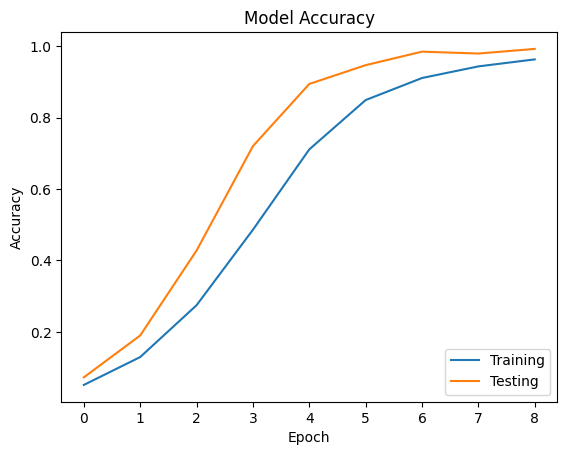

In [21]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

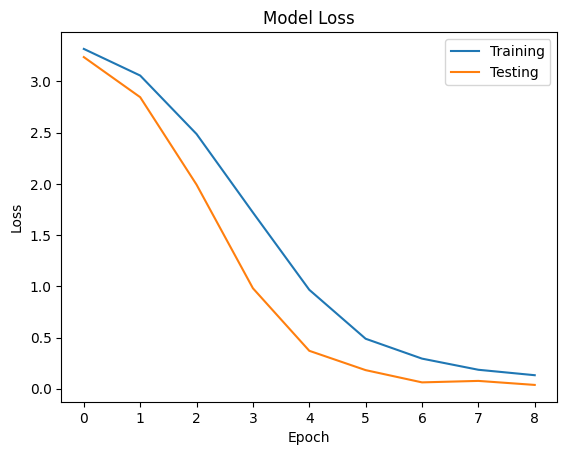

In [22]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [23]:
model.evaluate(validation_plant_generator, verbose=1)

66/66 [==============================] - 4s 64ms/step - loss: 0.0369 - accuracy: 0.9928


[0.03692539408802986, 0.9928160905838013]

In [24]:
model.save('/content/models/model_botanify.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
import pathlib
export_dir = '/content/models/saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('botanify.tflite')
tflite_model_file.write_bytes(tflite_model)

233606116